# Projeto 1 - Ciência dos Dados

Nome: Letícia Coêlho Barbosa

Nome: Matheus Silva Melo de Oliveira

## Contextualização

------------------------------------------------------------

O produto escolhido para a classificação foi a tão falada e renomada série do Universo de Star Wars,<em><b>The Mandalorian</b></em> atualmente vinculado, a Disney e transmitido no serviço de assinatura Disney+.

<br>

A classificação foi realizada com intuito de analisar caso internautas ou possíveis consumidores da série comentam sobre esta na rede social Twitter. O critério utilizado para relevância foi caso o usuário fizesse algum comentário que remetia algum laço de intensidade em relação à série, positivo ou não, como elogiando algum capítulo, sentindo saudade da série ou criticando algum aspecto relevante à obra. Tweets que falavam apenas de aspectos tangentes à esse certame, como elogios ou comentários a atores da obra, listagens no qual à série se enquadra e vagas menções sobre a série foram consideradas como irrelevantes nessa classificação.

<em>Alguns dos principais tópicos contidos nos tweets</em>
- Elogiando episódio final da segunda temporada
- Elogiando o personagem principal da obra, Mandaloriano ou o personagem em CGI, apeliadado de "Baby Yoda"
- Elogios à série, com advérbios que remetem falta da série, que está em hiato, ou elogios à história
- Comentários alheios a atores e atrizes da obra, como Pedro Pascal
- Comparações com outras obras, principalmente Wandavision, do mesmo serviço de streaming Disney+

<br>

<center><img src="mandalorian_assets/mandalorian.gif" width=500 style="float: center; margin: 0px 0px 10px 10px"></center>
<center><b>Cena da série do Disney+</b></center>

## Bibliotecas Utilizadas

------------------------------------------------------------

In [1896]:
#!pip install emoji
#!pip install pysinonimos

Carregando algumas bibliotecas:

In [1897]:
#Bibliotecas de uso recorrente
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [1898]:
#Bibliotecas com uso mais estrito com foco na classificação
import re 
import emoji
import pysinonimos.sinonimos as sn
import nltk
from emoji import UNICODE_EMOJI

Confirmando diretório de trabalho

In [1899]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\mathe_vz6v46f\OneDrive\Documentos\Arquivos INSPER 2° SEMESTRE\C-Dados\TheMandalorian


## Banco de Dados

------------------------------------------------------------

Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [1900]:
filename = 'mandalorian_assets/mandalorian.xlsx'

In [1901]:
train = pd.read_excel(filename)
train.head(5)

Treinamento  Relevancia
0  executivo da disney defendeu demissão de gina ...           0
1  @daredvevil nao seriooo melhor dia 😭 volta the...           1
2                  preciso terminar mandalorian logo           1
3  toda vez que eu vejo o baby yoda usando a forç...           0
4  jon fraveau eu te amo obrigado por fazer the m...           1

In [1902]:
test = pd.read_excel(filename, sheet_name = 'Teste').drop('Relevancia',axis=1)
test['Relevancia']=test['New']
test=test.drop('New',axis=1)
test.head()

Teste  Relevancia
0  the mandalorian é uma série com dinheiro e tec...           1
1  agora comecei mandalorian confiando novamente ...           1
2  @fepazo1 @gabriel_ns1999 @joelmsimmons @jurand...           1
3    eu assisti 3 minutos de mandalorian e emocionei           1
4  rt @anakinwar: já ta                          ...           0

## Classificador automático de sentimento

------------------------------------------------------------
Iniciando o tratamento e criação do modelo de classificação

___
### Definindo Funções


In [1903]:
#Limpando os tweets retirando pontos desnecessarios
def limpeza(tweet):
    punctuation = '[@\-/!.:?;,''"]'             
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern,'', tweet)
    return text_subbed

In [1904]:
#Limpando os tweets retirando emojis
def retira_emoji(content: str):
        modified = re.sub(emoji.get_emoji_regexp(), r"", content)
        modified = re.sub(':[^>]+:', '', modified)
        return modified.strip() 

In [1905]:
#Armazenando listas com preposições na língua portuguesa
nltk.download('stopwords')
prep = nltk.corpus.stopwords.words('portuguese')
prep.append('')

# Define função que aplica remoção de preposições
def limpa_preposicao(lista):
    sem_prep=[]     
    for palavra in lista: 
        if palavra in prep: 
            continue
        else:
            sem_prep.append(palavra)
            
    return sem_prep

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathe_vz6v46f\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1906]:
# Transformando tweets em lower case:
def lower(tweet):
    return tweet.lower()

In [1907]:
#retira escritas comuns em tweets, mas irrelevantes para análise de dados
def tweet_to_frase(lista):
    '''
    Aqui desconsideraremos as palavras "mandalorian" ou "the", visto que essas
    pertencem a  basicamente todo tweet analisado, e sua presença irá apenas impactar a base de dados
    com maior perncentualidade, no caso a de "relevantes".
    '''
    for i,word in enumerate(lista):
        if 'rt' in word or 'https' in word or'the' in word or 'mandalorian' in word:
            lista[i]=lista[i].replace(word,'null')
    new_list=[x for x in lista if x!='null']
    return new_list

In [1908]:
#Tornando os emojis em strings descritivas
#Alguns emojis não possuem transcrição para português
def transcreve_emoji(lista):
    emojis=re.findall(emoji.get_emoji_regexp(),lista)                  
    for i,emoji1 in enumerate(emojis):                              
            if emoji1 in UNICODE_EMOJI['pt']:
                emojis[i]=UNICODE_EMOJI['pt'][emoji1].replace(':',',')
            else:
                emojis[i]=UNICODE_EMOJI['en'][emoji1].replace(':',',')
    return emojis

In [1909]:
#Transformando lista em string
def list_to_string(lista):
    return ','.join(lista)

In [1910]:
#Transformando string em lista
def string_to_list(string):
    return string.split()

In [1911]:
#Aplicando todas as funções acima no df:
def aplica(tweet):
    
    #captando emojis
    emoji_transcrito=list_to_string(transcreve_emoji(tweet))
    
    #aplicando todas as funções definidas
    frase_separada=list_to_string(tweet_to_frase(limpa_preposicao(string_to_list(limpeza(lower(retira_emoji(tweet)))))))
    
    #retornando uma string limpa e com emojis transcritos
    return frase_separada+','+emoji_transcrito

In [1912]:
def frases_to_words (Serie_frases):
    
    texto=''
    
    for palavra in Serie_frases:
        texto+=str(palavra)                        #Criando uma string gigante com todas as palavras das frases
    
    lista_palavras=texto.split(',')                #Criando lista das palavras contidas na variável texto
    return pd.Series(lista_palavras)               #Retornando uma série de palavras contida nas frases

___
### Montando um Classificador Naive-Bayes



Considerando apenas as mensagens da planilha Treinamento:

In [1913]:
#Transformando palavras em variáveis categóricas:
train['Treinamento'] = train['Treinamento'].astype('category')
test['Teste'] = test['Teste'].astype('category')

In [1914]:
#Aplicando funções de limpeza e certificação no dataframe de treinamento da base de dados:
train['Clean']=train['Treinamento'].apply(aplica)
test['Clean']=test['Teste'].apply(aplica)

In [1915]:
#Separando dados de treino por relevância:
train_relevantes=train[train['Relevancia']==1]
train_irrelevantes=train[train['Relevancia']==0]

In [1916]:
#Serie de palavras relevantes e irrelevantes no conjunto treino:
palavras_r= frases_to_words(train_relevantes['Clean'])
palavras_i= frases_to_words(train_irrelevantes['Clean'])

In [1917]:
# Frequências relativas das palavras:
rel_relevantes=palavras_r.value_counts(normalize=True)
rel_irrelevantes=palavras_i.value_counts(normalize=True)

In [1918]:
#Guardando uma lista as palavras pertencentes aos tweets relevantes:
list_i=palavras_i.tolist()

#Guardando uma lista as palavras pertencentes aos tweets irrelevantes:
list_r=palavras_r.tolist()

#Guardando em uma lista todas as palavras possíveis na base de dados (SEM REPETIÇÕES):
elementos_nao_repetidos=set(list_i+list_r)

In [1919]:
#Série representante do conjunto universo de todas as palavras:
#total=palavras_i+palavras_r
total=pd.Series(list_i+list_r)

In [1920]:
#Frequência relativa das palavras no total:
rel_total=total.value_counts(True)

### Montando as Probabilidades 

$$ P_{relevante}= \frac{Palavras_{relevantes}}{Total_{palavras}} $$

$$ P_{irrelevante}= \frac{Palavras_{irrelevantes}}{Total_{palavras}} $$

Onde, sabemos que:

$$ P_{relevante}+ P_{irrelevante}=1 $$

In [1921]:
#Probabilidade tweet ser relevante ou irrelevante:
P_r=len(palavras_r)/len(total)
P_i=len(palavras_i)/len(total)

#Garantindo a verdade acima
assert P_r+P_i==1

Ingenuidade do classificador Naïve-Bayes:

$$ P(R|tweet)= \frac{P(tweet \cap R)}{P(tweet)} $$
$$ P(tweet|R)= \frac{P(tweet \cap R)}{P(R)} $$

$$ P(tweet \cap R) = P(R|tweet) P(tweet) $$
$$ P(tweet \cap R) = P(tweet|R) P(R) $$

Sendo a Probabilidade de Naïve-Bayes:
    

$$ P(R|tweet)= \frac{P(tweet|R) P(R)}{P(tweet)} $$

A probabilidade $P(tweet|R)$, pode ser calculada considerando a independência entre as palavras, ou seja, a probabilidade de certa palavra aparecer não interfere na probabilidade de outras:

$$ P(tweet|R) = P(palavra1|R)P(palavra2|R)...P(palavraN|R)$$

Temos portanto como probabilidade de um tweet ser relevante:

$$ P(R|tweet) = \frac{P(palavra1|R)P(palavra2|R)...P(palavraN|R) P(R)}{P(tweet)}$$

Analogamente, para $P(I|tweet)$, teriamos:

$$P(I|tweet)=\frac{P(palavra1|I)P(palavra2|I)...P(palavraN|I) P(I)}{P(tweet)}$$

Caso apareça uma palavra estranha ou que não esteja na base de dados, precisamos amplificar nosse leque de equações utilizando um recurso matemático conhecido como <b><em>Suavização de Laplace</em></b>, que consiste em basicamente "incluir" a nova palavra no âmbito das probabilidades relativas de uma determinada palavra ser classificada como Relevante ou Irrelevante.

Para realizar tal recurso, devemos analisar quantas vezes a palavra analisada aparece no absolutamente na comapração em questão, seja relevante ou irrelavante, somar uma unidade (que evita o <b>0</b>) no numerador, e somar a quantidade de "possíveis palavras no denominador", isto é a quantidade de palavras únicas pertencentes ao dataset de tweets relevantes ou irrelevantes. Matematicamente teremos:

$$P(palavra1|R) = \frac{F_{AR}+1}{P_{R}+P_p}$$

$$P(palavra1|I) = \frac{F_{AI}+1}{P_{I}+P_p}$$

Onde: 

$ F_{AR}$: Frequência absoluta de tweets relevantes 

$ F_{AI}$: Frequência absoluta de tweets relevantes
    
$P_{R}$: Todas as palavras pertencentes aos tweets rotulados como relevantes
    
$P_{I}$: Todas as palavras pertencentes aos tweets rotulados como irrelevantes

$P_p$: Todas as palavras possíveis na base de dados de treinamento

Portanto,feitas modificações, palavra a palavra, a função Naïve-Bayes classificaria como relevante caso:

$$\frac{P(R|tweet)P(Relevante)}{P(tweet)} > \frac{P(I|tweet)P(Irrelevante)}{P(tweet)}$$



Logo:

$$P(R|tweet)P(Relevante) > P(I|tweet)P(Irrelevante)$$

### Feita a análise teórica, vamos implantar o modelo:

In [1922]:
#Calcula a frequência absoluta da palavra no respectivo conjunto de dados
def freq_absoluta(palavra,lista):
    count=0
    for i in range(0,len(lista)):
        if palavra==lista[i]:
            count+=1
        else:
            continue
    return count

In [1923]:
#Aplicando a suavização de laplace
def laplace(frequencia_absoluta,palavras_pertecentes_a_classe):
    return (frequencia_absoluta+1)/(len(palavras_pertecentes_a_classe)+len(elementos_nao_repetidos))

In [1924]:
def P_tweet_r(tweet):
    '''
    Calcula a probabilidade do tweet ser relevante
    '''
    prob_tweet=1 #Cont
    quebra_tweet=tweet.split(',')
    for palavra in quebra_tweet:
        fa=freq_absoluta(palavra,list_r)
        prob_palavra=laplace(fa,list_r)
        prob_tweet*=prob_palavra
           
    return prob_tweet

In [1925]:
def P_tweet_i (tweet):
    '''
    Calcula a probabilidade do tweet ser irrelevante
    '''
    prob_tweet=1 #Cont
    quebra_tweet=tweet.split(',')
    for palavra in quebra_tweet:
        fa=freq_absoluta(palavra,list_i)
        prob_palavra=laplace(fa,list_i)
        prob_tweet*=prob_palavra
           
    return prob_tweet

In [1926]:
#Criando Nossa função de retorno Naive_Bayes:
def Naive_Bayes (tweet):
    if(P_tweet_r(tweet)*P_r > P_tweet_i(tweet)*P_i):
        return 1
    else:
        return 0

#####  Vendo a eficácia do modelo no conjunto de treinamento

In [1927]:
#Criando uma nova coluna para armazenar resultado da nossa função Naïve_Bayes
train['Classificador']=train.Clean.apply(Naive_Bayes)

In [1928]:
train.head()

Treinamento  Relevancia  \
0  executivo da disney defendeu demissão de gina ...           0   
1  @daredvevil nao seriooo melhor dia 😭 volta the...           1   
2                  preciso terminar mandalorian logo           1   
3  toda vez que eu vejo o baby yoda usando a forç...           0   
4  jon fraveau eu te amo obrigado por fazer the m...           1   

                                               Clean  Classificador  
0  executivo,disney,defendeu,demissão,gina,carano...              0  
1  daredvevil,nao,seriooo,melhor,dia,volta,precis...              1  
2                             preciso,terminar,logo,              1  
3  toda,vez,vejo,baby,yoda,usando,força,lembro,me...              0  
4       jon,fraveau,amo,obrigado,fazer,big,fan,here,              1

In [1929]:
#Porcentagem de acerto de acerto no conjunto de Treino:

x=train.loc[(train['Classificador']==1)&(train['Relevancia']==1),:].shape[0]
y=train.loc[(train['Classificador']==0)&(train['Relevancia']==0),:].shape[0]
print('A acurácia do modelo foi de: ',100*(x+y)/train.shape[0],'%')

A acurácia do modelo foi de:  90.6 %


In [1930]:
#Vendo a classificação efetiva 
pd.crosstab(train.Relevancia,train.Classificador,normalize=True)*100

Classificador     0     1
Relevancia               
0              34.4   9.4
1               0.0  56.2

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [1931]:
#Aplicando no dataframe de teste
test['Classificador']=test.Clean.apply(Naive_Bayes)

In [1932]:
x=test.loc[(test['Classificador']==1)&(test['Relevancia']==1),:].shape[0]
y=test.loc[(test['Classificador']==0)&(test['Relevancia']==0),:].shape[0]
print('A acurácia do modelo foi de: ',100*(x+y)/test.shape[0],'%')

A acurácia do modelo foi de:  55.111111111111114 %


In [1933]:
#Vendo a classificação efetiva 
pd.crosstab(test.Relevancia,test.Classificador,normalize=True)*100

Classificador          0          1
Relevancia                         
0              15.555556  42.666667
1               2.222222  39.555556

In [1934]:
serie_0_test = test[test["Classificador"] == 0]
serie_1_test = test[test["Classificador"] == 1]

# Valores iniciais das quantidades de cada caso
verdadeiros_positivos = 0
falsos_positivos = 0
verdadeiros_negativos = 0
falsos_negativos = 0

# Calcula a quantidade de tweets de cada um dos casos acima
for i in range(len(test['Classificador'])):
    if test['Classificador'][i] == 1 and test['Relevancia'][i] == 1:
        verdadeiros_positivos += 1
    elif test['Classificador'][i] == 0 and test['Relevancia'][i] == 1:
        falsos_positivos += 1
    elif test['Classificador'][i] == 0 and test['Relevancia'][i] == 0:
        verdadeiros_negativos += 1
    elif test['Classificador'][i] == 1 and test['Relevancia'][i] == 0:
        falsos_negativos += 1

# Retorna probabilidade para cada caso
print("Contagem\t\tProbabilidade")
print("----------------------------------------")
print("%s:\t\t%f" % ('Verdadeiros Positivos', verdadeiros_positivos/len(serie_1_test['Classificador'])))
print("%s:\t\t%f" % ('Falsos Positivos', falsos_positivos/len(serie_0_test['Classificador'])))
print("%s:\t\t%f" % ('Verdadeiros Negativos', verdadeiros_negativos/len(serie_0_test['Classificador'])))
print("%s:\t\t%f" % ('Falsos Negativos', falsos_negativos/len(serie_1_test['Classificador'])))

Contagem		Probabilidade
----------------------------------------
Verdadeiros Positivos:		0.481081
Falsos Positivos:		0.125000
Verdadeiros Negativos:		0.875000
Falsos Negativos:		0.518919


___
### Concluindo

In [1935]:
pd.crosstab(test.Relevancia,test.Classificador,normalize=False)

Classificador   0   1
Relevancia           
0              35  96
1               5  89

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [1936]:
#Utilizaremos aqui o módulo sklearn que é próprio para análises de Machine Learning

In [1937]:
#Juntando os tweets em um unico DF
test = pd.read_excel(filename, sheet_name = 'Teste').drop('Relevancia',axis=1)
test['Relevancia']=test['New']
test['Total']=test['Teste']
test=test.drop(['New','Teste'],axis=1)

train = pd.read_excel(filename, sheet_name = 'Treinamento')
train['Total']=train['Treinamento']
train=train.drop('Treinamento',axis=1)

#Concatenando as tabelas
data_set=pd.concat([train,test])

#Limpando os tweets
data_set['Clean']=data_set['Total'].apply(aplica)
data_set.head()

Relevancia                                              Total  \
0           0  executivo da disney defendeu demissão de gina ...   
1           1  @daredvevil nao seriooo melhor dia 😭 volta the...   
2           1                  preciso terminar mandalorian logo   
3           0  toda vez que eu vejo o baby yoda usando a forç...   
4           1  jon fraveau eu te amo obrigado por fazer the m...   

                                               Clean  
0  executivo,disney,defendeu,demissão,gina,carano...  
1  daredvevil,nao,seriooo,melhor,dia,volta,precis...  
2                             preciso,terminar,logo,  
3  toda,vez,vejo,baby,yoda,usando,força,lembro,me...  
4       jon,fraveau,amo,obrigado,fazer,big,fan,here,

In [1947]:
#Seperando aleatoriamente
#Considerando que temos 725 tweets, e fora solicitado 200-300, precisaremos de 200/500, ou seja, cerca de 290 tweets
#Para o split. Essa porcentagem é de 0.40, que colocaremos no parâmetros abaixo

from sklearn.model_selection import train_test_split

#Quebrando nossos atributos e rótulos aleatoriamente pelo método abaixo:
#OBS: Como não utilizamos o parâmetro random_state=number, estamos garantindo que a cada loop sobre o split
#será aleatoriamente e diferentemente organizado
lista_hist=[]
for i in range(0,100):
    X_train,X_test,y_train,y_test=train_test_split(data_set[['Clean','Relevancia']],data_set.Relevancia,
                                               test_size=0.40)
    
    train_relevantes=X_train[X_train['Relevancia']==1]
    train_irrelevantes=X_train[X_train['Relevancia']==0]
    
    
    palavras_r= frases_to_words(train_relevantes['Clean'])
    palavras_i= frases_to_words(train_irrelevantes['Clean'])
    
    list_i=palavras_i.tolist()


    list_r=palavras_r.tolist()

    elementos_nao_repetidos=set(list_i+list_r)
    
    def laplace(frequencia_absoluta,palavras_pertecentes_a_classe):
        return (frequencia_absoluta+1)/(len(palavras_pertecentes_a_classe)+len(elementos_nao_repetidos))
    
    def P_tweet_r(tweet):
        '''
        Calcula a probabilidade do tweet ser relevante
        '''
        prob_tweet=1 #Cont
        quebra_tweet=tweet.split(',')
        for palavra in quebra_tweet:
            fa=freq_absoluta(palavra,list_r)
            prob_palavra=laplace(fa,list_r)
            prob_tweet*=prob_palavra

        return prob_tweet

    def P_tweet_i (tweet):
        '''
        Calcula a probabilidade do tweet ser irrelevante
        '''
        prob_tweet=1 #Cont
        quebra_tweet=tweet.split(',')
        for palavra in quebra_tweet:
            fa=freq_absoluta(palavra,list_i)
            prob_palavra=laplace(fa,list_i)
            prob_tweet*=prob_palavra

        return prob_tweet

    def Naive_Bayes (tweet):
        if(P_tweet_r(tweet)*P_r > P_tweet_i(tweet)*P_i):
            return 1
        else:
            return 0
    
   
    X_test['Classificador']=X_test.Clean.apply(Naive_Bayes)
    
    a=X_test.loc[(X_test['Classificador']==1)&(X_test['Relevancia']==1),:].shape[0]
    b=X_test.loc[(X_test['Classificador']==0)&(X_test['Relevancia']==0),:].shape[0]
    
    lista_hist.append((a+b)/X_test.shape[0])


<IPython.core.display.Javascript object>


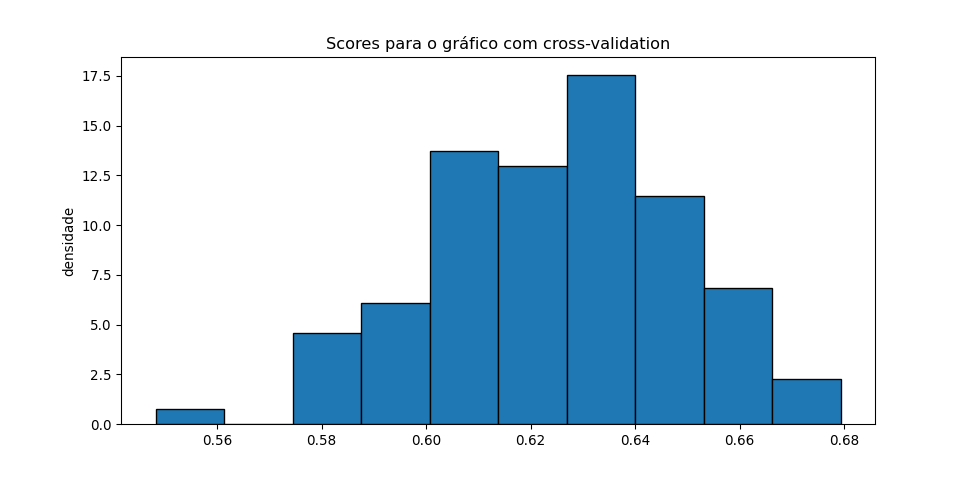

In [1952]:
plt.figure(figsize=(10, 5))
plt.hist(lista_hist, bins=10, edgecolor='black', density=True)
plt.title('Scores para o gráfico com cross-validation')
plt.ylabel('densidade')
plt.show()

In [1953]:
'''Podemos ver que realizando a chamada Cross-Validation, o processo de variar aleatoriamente 
conjunto de treino-teste, pode aumentar a possibilidade de scores melhores, dado que o melhor conjunto pode ser obtido
sempre com diferentes configurações. No caso vemos acima que basicamente quase todas as configurações acima tem melhores
scores que os obtidos pelo nosso modelo na conjuntura obtida.
Dessa forma podemos concluir que a utilização de validação cruzada é extramente útil para encontrar a melhor
conjuntura do conjunto de treino e de teste'''

'Podemos ver que realizando a chamada Cross-Validation, o processo de variar aleatoriamente \nconjunto de treino-teste, pode aumentar a possibilidade de scores melhores, dado que o melhor conjunto pode ser obtido\nsempre com diferentes configurações. No caso vemos acima que basicamente quase todas as configurações acima tem melhores\nscores que os obtidos pelo nosso modelo na conjuntura obtida.\nDessa forma podemos concluir que a utilização de validação cruzada é extramente útil para encontrar a melhor\nconjuntura do conjunto de treino e de teste'

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)


In [60]:
def dicio_r (palavra):
    
    nova=sn.Search(palavra).synonyms()   #Buscando sinônimos
    P_nova=0
    
    if nova != 404:
        
        for i in range(len(nova)):
        
            if (i != len(nova)-1):
                if (nova[i] in palavras_r) and (nova[i] not in lista_r):
                    P_nova=rel_relevantes[nova[i]]
                    return P_nova
                else:
                    continue

            else:
                return 1
    else:
        return 1
        

In [ ]:
def dicio_i (palavra):
    
    nova=sn.Search(palavra).synonyms()   #Buscando sinônimos
    P_nova=0
    
    if nova != 404:
    
        for i in range(len(nova)):
            
            if (i != len(nova)-1):
            
                if (nova[i] in palavras_r) and (nova[i] not in lista_i):
                    P_nova=rel_relevantes[nova[i]]
                    return P_nova
                else:
                    continue
            
            else:
                return 1
    else:
        return 1
        

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**